# Demo of `litholog` functionality

litholog is a package-level extension of agile-geoscience/striplog, with additional features that focus on lithology, and an API that is geared toward facilitating machine learning and quantitative analysis.

The package provides two primary data structures:

- `Bed`
    - stores data from one bed (e.g., top, base, lithology, thickness, grain size, etc).
    - is equivalent to a `striplog.Interval`

- `BedSequence`
    - stores a collection of `Beds` in stratigraphic order 
    - is equivalent to a `striplog.Striplog`


Other utilities include:
- transformations for grain-size data from millimeter (mm) to log2 (a.k.a. Psi) units, which are far easier to work with than mm. 
- calculation of the following metrics at the `BedSequence` level:
    - net-to-gross
    - amalgamation ratio
    - psuedo gamma ray log
    - Hurst statistics (for determining facies clustering)
- default lithology colors

The data provided with this demo come from a paper by Zane Jobe et al. ([html](https://doi.org/10.1111/j.1365-3091.2011.01283.x), [pdf](http://www.academia.edu/download/31596179/Jobe_et_al_2012_Sed-_Climbing_ripple_successions_in_turbidite_systems.pdf)), and there are 19 graphic logs in that paper, all of which were digitized using the Matlab digitizer included with this release. 

An example log from that paper is shown here, drafted in a vector-drawing program:
<img src="../data/example_log.png" alt="Example graphic log from Jobe et al. (2012)" width="300"/>

It was then digitized using the Matlab digitizer, and when plotted with litholog looks like this:

IMAGE

# NOTES FOR ROSS:
- I dont think the filter_nan_gaussian gets used? 
- component_map?

---
---


## Import some packages, including `litholog`

In [1]:
import collections
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import litholog
from litholog import utils, Bed
from litholog.sequence import io, BedSequence

In [2]:
#defaults legend for plotting
litholog.defaults.litholegend

Legend(Decor({'component': Component({'lithology': 'mud'}), '_colour': '#ad8150', 'hatch': None, 'width': -6.0})
Decor({'component': Component({'lithology': 'sand'}), '_colour': '#fffe7a', 'hatch': '.', 'width': -1.0})
Decor({'component': Component({'lithology': 'gravel'}), '_colour': '#ff9408', 'hatch': 'o', 'width': 4.0})
Decor({'component': Component({'lithology': 'missing'}), '_colour': '#ffffff', 'hatch': 'x', 'width': -1.0}))

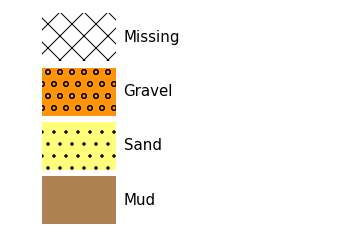

In [3]:
# and this is how Beds will look when plotted
litholog.defaults.litholegend.plot()

In [4]:
# modify the legend
litholog.defaults.sand_decor.colour = 'blue'

# and see if it worked
litholog.defaults.litholegend

Legend(Decor({'component': Component({'lithology': 'mud'}), '_colour': '#ad8150', 'hatch': None, 'width': -6.0})
Decor({'component': Component({'lithology': 'sand'}), '_colour': '#0000ff', 'hatch': '.', 'width': -1.0})
Decor({'component': Component({'lithology': 'gravel'}), '_colour': '#ff9408', 'hatch': 'o', 'width': 4.0})
Decor({'component': Component({'lithology': 'missing'}), '_colour': '#ffffff', 'hatch': 'x', 'width': -1.0}))

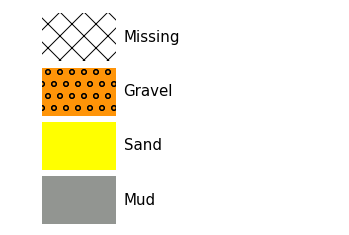

In [202]:
# modify things again
litholog.defaults.sand_decor.colour = 'yellow'
litholog.defaults.sand_decor.hatch = None

# call the plot function this time - note sand doesnt have dots any more
litholog.defaults.litholegend.plot()

# Make a `Bed` and a `BedSequence` from scratch
would be better to make a list of tops, bases, and zip it that way...

In [205]:
bed1 = Bed(top = 1, base = 0, data = {'lithology':'sand'})
bed2 = Bed(top = 1.1, base = 1, data = {'lithology':'mud'})
bed3 = Bed(top = 1.8, base = 1.1, data = {'lithology':'sand'})

bed_x = Bed(0,1,{'lithology':'sand'})

print(bed2,'\n')

print(bed1.order)
print(bed_x.order,'\n')

print(bed1['lithology'])

TypeError: __init__() missing 1 required positional argument: 'base'

In [67]:
seq1 = BedSequence([bed1, bed2, bed3])
seq1

Striplog(3 Intervals, start=0.0, stop=1.8)

ValueError: min() arg is an empty sequence

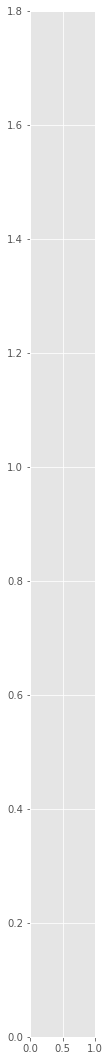

In [68]:
seq1.plot()

# Demo data

## Load the raw `csv` data

This first step uses `utils` within litholog to converts depth-grainsize pairs (e.g., that define a fining-upward profile in a bed) into pandas-friendly arrays. The outputs of this will be the fields shown below (e.g., depth_m, grain_size_mm). If you have differently formatted csv data, this step may not apply, or you may need a different util.

In [70]:
# Converts 'string' arrays to numpy
transforms = {c : utils.string2array_pandas for c in ['depth_m', 
                                                      'grain_size_mm', 
                                                      'grain_size_psi']}

# Read the demo data
df = pd.read_csv('../data/demo_sequences.csv', converters=transforms)

# counts and prints the names of the logs in the data file
print(len(df.name.unique()),
      'graphic logs imported:',
      '\n',
      df.name.unique()) 

df.head() # displays the first five rows of data

19 graphic logs imported: 
 ['Pukearuhue' 'Magnolia' 'Karoo krf1' 'Karoo krf2' 'Karoo krf3'
 'Karoo krf4' 'Karoo krf5' 'Karoo krf6' 'Karoo krf7' 'Karoo krf8'
 'Karoo krf9' 'Karoo krf10' 'Karoo krf11' 'Karoo krf12' 'Karoo krf13'
 'Karoo krf14' 'Karoo krf15' 'Karoo krf16' 'Karoo krf17']


,name,count,collection,eod,eodnum,tops,th,gs_tops_mm,gs_tops_psi,snd_shl,mean_gs_mm,mean_gs_psi,max_gs_mm,max_gs_psi,ng,ar,depth_m,grain_size_mm,grain_size_psi
0,Pukearuhue,226,Mount Messenger,levee,3,66.907008,0.234645,0.001000,-9.9658,0.0,0.001000,-9.9658,0.001000,-9.9658,0.602931,0.08134,"[66.907, 66.6724]","[0.001, 0.001]","[-9.9658, -9.9658]"
1,Pukearuhue,226,Mount Messenger,levee,3,66.672363,0.933692,0.122591,-3.0281,1.0,0.129950,-2.9440,0.133845,-2.9014,0.602931,0.08134,"[66.6724, 66.5795, 66.3448, 66.1151, 65.9244, ...","[0.1226, 0.1262, 0.1285, 0.1315, 0.1331, 0.133...","[-3.028, -2.9862, -2.9602, -2.9269, -2.9094, -..."
2,Pukearuhue,226,Mount Messenger,levee,3,65.738672,0.232201,0.105433,-3.2456,1.0,0.105433,-3.2456,0.105433,-3.2456,0.602931,0.08134,"[65.7387, 65.5065]","[0.1054, 0.1054]","[-3.2461, -3.2461]"
3,Pukearuhue,226,Mount Messenger,levee,3,65.506471,0.222424,0.115450,-3.1147,1.0,0.137917,-2.8581,0.150254,-2.7345,0.602931,0.08134,"[65.5065, 65.4918, 65.4356, 65.372, 65.3476, 6...","[0.1154, 0.1203, 0.1306, 0.1446, 0.1503, 0.1503]","[-3.1153, -3.0553, -2.9368, -2.7899, -2.7341, ..."
4,Pukearuhue,226,Mount Messenger,levee,3,65.284047,0.193093,0.110490,-3.1780,1.0,0.129487,-2.9491,0.141708,-2.8190,0.602931,0.08134,"[65.284, 65.2327, 65.1716, 65.1301, 65.091]","[0.1105, 0.1221, 0.1329, 0.1417, 0.1417]","[-3.1779, -3.0339, -2.9116, -2.8191, -2.8191]"


The variable `df` is just a pandas DataFrame at this point - it hasn't been put into `litholog` format yet. 

Notice that the columns `ng` (net-to-gross) and `ar` (amalgamation ratio) are the same for each graphic log. This csv was processed using Matlab, and `ng` and `ar` were calculated there. Not to worry, `litholog` can also calculate these metrics, which we will show you how to do below. 

--- 

---

## Convert groups to `BedSequence`s

This is the step that will convert `df` into `BedSequences` (equivalent to a `striplog.Striplog`) that contains `Beds` (equivalent to `striplog.Intervals`):

In [71]:
# Columns shared by whole sequences (i.e., shared by an entire graphic log)
METACOLS = ['name', 'count', 'collection', 'eod', 'eodnum', 'ng', 'ar']

# Columns of bed-level data
DATACOLS = ['th', 'gs_tops_mm', 'snd_shl', 'depth_m',
            'gs_tops_mm', 'mean_gs_mm', 'max_gs_mm', 'grain_size_mm',
            'gs_tops_psi', 'mean_gs_psi', 'max_gs_psi', 'grain_size_psi']

# Convert to a list of `BedSequence`s
seqs = []
for name, seq_df in df.groupby('name'):
    seqs.append(
        BedSequence.from_dataframe(
            seq_df, 
            thickcol='th',
            component_map=litholog.defaults.DEFAULT_COMPONENT_MAP,
            metacols=METACOLS,
            datacols=DATACOLS,
        )
    )
    

# Show name + eod + number of beds of each
[(s.metadata['name'], s.metadata['eod'], len(s)) for s in seqs]

[('Karoo krf1', 'fan', 105),
 ('Karoo krf10', 'fan', 221),
 ('Karoo krf11', 'fan', 47),
 ('Karoo krf12', 'fan', 35),
 ('Karoo krf13', 'fan', 51),
 ('Karoo krf14', 'fan', 96),
 ('Karoo krf15', 'fan', 54),
 ('Karoo krf16', 'fan', 167),
 ('Karoo krf17', 'fan', 97),
 ('Karoo krf2', 'fan', 20),
 ('Karoo krf3', 'fan', 42),
 ('Karoo krf4', 'fan', 15),
 ('Karoo krf5', 'fan', 51),
 ('Karoo krf6', 'fan', 288),
 ('Karoo krf7', 'fan', 205),
 ('Karoo krf8', 'fan', 244),
 ('Karoo krf9', 'fan', 191),
 ('Magnolia', 'fan', 180),
 ('Pukearuhue', 'levee', 209)]

In [129]:
# Choose one to use as an example
mag = seqs[-2] # the second to last one


print('This is a core, so it has order =\n',
      mag.order,
      '\nall other demo BedSequences are \'elevation\' ordered')

mag.values('top')

This is a core, so it has order =
 depth 
all other demo BedSequences are 'elevation' ordered


TypeError: 'numpy.ndarray' object is not callable

In [124]:
print(mag.metadata)

mag.metadata['ng']

{'name': 'Magnolia', 'count': 225, 'collection': 'Gulf of Mexico', 'eod': 'fan', 'eodnum': 1, 'ng': 0.8307400555777629, 'ar': 0.403314917127072}


0.8307400555777629

In [166]:
print(type(mag.get_field('th')))
print(mag.get_field('th'))

<class 'numpy.ndarray'>
[0.22943441 0.63747398 0.62997429 0.25498959 0.16499327 0.37498469
 0.1199951  0.78039575 0.5401963  0.27009815 0.14630316 0.39389314
 0.13504908 0.46141767 0.27009815 0.45016358 0.1125409  0.47267176
 0.05627045 0.48392585 0.04416498 0.45219573 0.46181691 0.39446861
 0.24052964 0.30787794 0.30787794 0.37522624 0.34636268 0.1346966
 0.15393897 0.81780078 0.04810593 0.37522624 0.07696949 0.42333217
 0.02886356 0.41371098 0.18627915 0.13711046 0.14765742 0.16875133
 0.15820437 0.36914354 0.20039221 0.61172358 0.02109392 0.5800827
 0.03164087 0.47461312 0.13711046 0.47461312 0.14765742 0.47461312
 0.39023746 0.44297225 0.39023746 0.26889862 0.46971217 0.54588171
 0.50779694 0.12694923 0.12694923 0.06347462 1.04098373 0.20311878
 0.19042385 0.74900049 0.08886446 0.41893248 0.19042385 0.35545786
 0.05077969 0.49510202 0.05077969 0.6775998  0.1904412  0.52053928
 0.4443628  0.22852944 0.3808824  0.55862752 0.3808824  1.1426472
 0.35549024 0.10156864 0.62210792 0.48245

In [160]:
print('total thickness is',mag.get_field('th').sum(),'meters')
print('maximum Bed thickness is',mag.max_field('th'),'meters')
print('minimum Bed thickness is',mag.min_field('th'),'meters')

print(mag.unique)

total thickness is 59.9993475938424 meters
maximum Bed thickness is 1.2040773099781699 meters
minimum Bed thickness is 0.009328660493544309 meters
[(Component({'lithology': 'sand'}), 49.843861354738145), (Component({'lithology': 'mud'}), 10.155486239104247)]


Now let's take a look at one `Bed`. All `Beds` must have a `top`, `base`, and `data`, which can be array or dict-like

In [161]:
mag[0]

Interval({'data': {'th': 0.229434414975288, 'gs_tops_mm': 0.0102898068931541, 'snd_shl': 0.0, 'depth_m': array([0.    , 0.2294]), 'mean_gs_mm': 0.0102898068931541, 'max_gs_mm': 0.0102898068931541, 'grain_size_mm': array([0.0103, 0.0103]), 'gs_tops_psi': -6.6026, 'mean_gs_psi': -6.6026, 'max_gs_psi': -6.6026, 'grain_size_psi': array([-6.6012, -6.6012])}, 'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}), 'base': Position({'middle': 0.229434414975288, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'mud'})]})

In [167]:
mag[-1].top

upper,59.4676139457105
middle,59.4676139457105
lower,59.4676139457105


In [171]:
print(mag[-1].top.upper) # see the striplog Interval class for info on upper, middle, and lower
print(mag[-1].primary.lithology)
print(mag[-1].data['mean_gs_psi'])
print(litholog.wentworth.psi2name(mag[-1].data['mean_gs_psi']))

59.4676139457105
sand
-2.705
f_sand


In [172]:
for bed in mag:
    print(bed.top.upper)

0.0
0.229434414975288
0.8669083960878299
1.49688268330493
1.7518722757499499
1.9168655414496598
2.29185023622175
2.4118453385488103
3.1922410862993105
3.7324373868347203
4.00253553710243
4.14883870183077
4.54273183763784
4.6777809127716905
5.139198586145692
5.409296736413388
5.859460320192901
5.97200121613778
6.444672979106271
6.5009434270787
6.984869279641679
7.029034259047919
7.48122998481931
7.94304689624541
8.33751550808854
8.5780451494563
8.885923090407037
9.19380103135778
9.56902727189149
9.91538995546106
10.050086554627
10.2040255251024
11.021826305752802
11.0699322340263
11.445158474560001
11.5221279597977
11.945460128605001
11.9743236855691
12.3880346687217
12.5743138153561
12.7114242727109
12.859081688323698
13.0278330204527
13.1860373943236
13.555180933355699
13.755573140258901
14.3672967192264
14.3883906357425
14.968473339935901
15.0001142147101
15.4747273363228
15.6118377936776
16.086450915290403
16.234108330903197
16.708721452516
17.098958908064198
17.5419311549028
17.932

## Basic Plotting

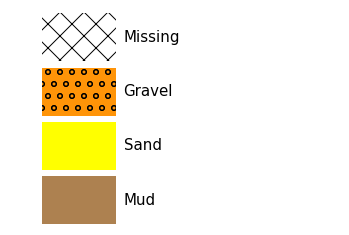

In [173]:
litholog.defaults.litholegend.plot()

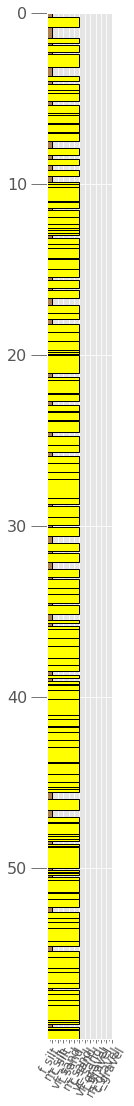

In [176]:
# the most simple plot, but doesnt include any bed-level grain size data
# since this is a core, it plots depth-ordered
mag.plot()


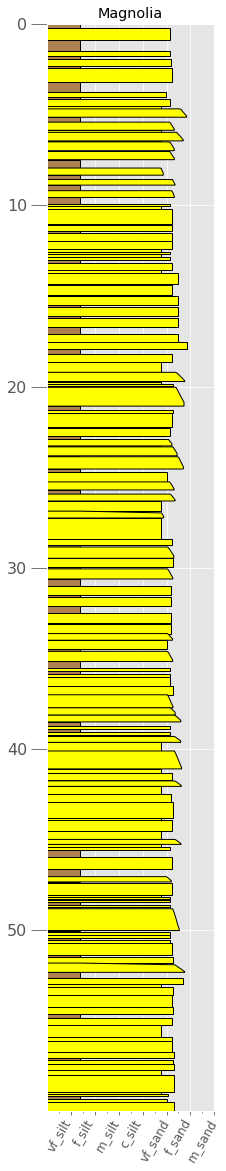

In [180]:
# here is a little nicer way to plot it that includes the grain size data for each bed

fig, ax = plt.subplots(figsize=[3,20])

seq_num = -2

seqs[seq_num].plot(ax=ax,
                   legend=litholog.defaults.litholegend,
                   width_field='grain_size_psi',
                   depth_field='depth_m',
                   wentworth='fine'
                  )

ax.set_title(seqs[seq_num].metadata['name']);

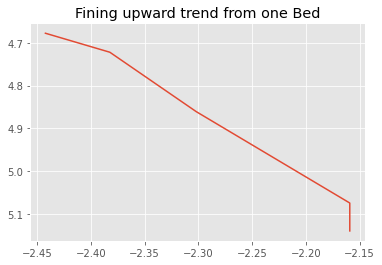

In [210]:
gs=mag[13].data['grain_size_psi'] # get just one field from a Bed
de=mag[13].data['depth_m'] 

plt.plot(gs,de)
plt.gca().invert_yaxis() # need to do this because it's depth-ordered
plt.title('Fining upward trend from one Bed');

(-3.5, -2.0)

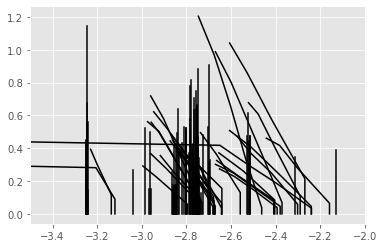

In [228]:
fig, ax = plt.subplots()
for bed in mag:
    if bed.data['snd_shl']==1.0:
        gs=bed.data['grain_size_psi']
        de=bed.data['depth_m']
        de=np.max(de)-de # normalize to zero so they will all plot together
        ax.plot(gs,de,'k')
plt.gca().set_xlim([-3.5,-2]) # do this because some sand beds go all the way to clay

## Flipping depth -> elevation

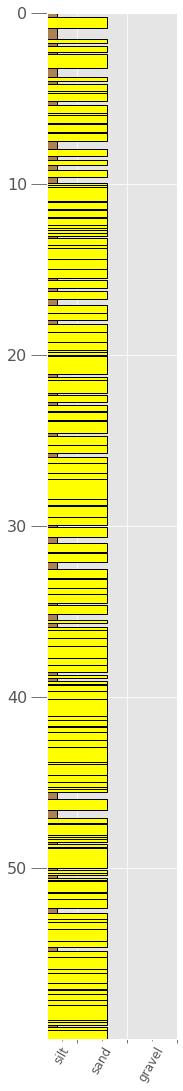

In [181]:
# depth version (this is only depth-ordered one in demo)
seqs[-2].plot(legend=litholog.defaults.litholegend, 
             fig_width=3, aspect=5, wentworth='coarse')

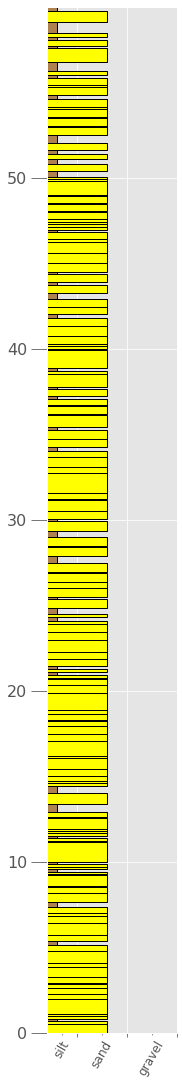

In [182]:
# to elevation
seqs[-2].flip_convention(depth_key='depth_m').plot(
             legend=litholog.defaults.litholegend, 
             fig_width=3, aspect=5, wentworth='coarse')

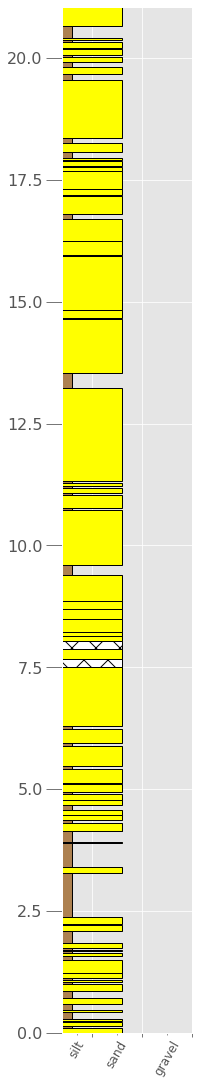

In [183]:
# Specify a legend when plotting (otherwise random used)
# `wentworth` can use 'fine' or 'coarse' bins

# elevation_version
example_seq.plot(legend=litholog.defaults.litholegend, 
                 fig_width=3, aspect=5, wentworth='coarse')

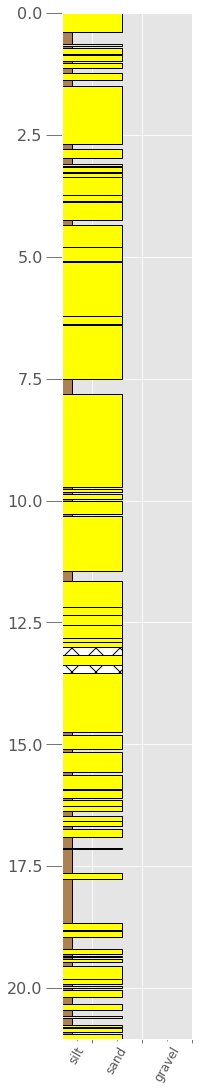

In [184]:
# to depth
example_seq.flip_convention(depth_key='depth_m').plot(
          legend=litholog.defaults.litholegend, 
          fig_width=3, aspect=5, wentworth='coarse')

In [185]:
example_seq.order

'elevation'

In [186]:
example_seq.shift(delta=-example_seq.stop.z).order

'depth'

# Some Basic Stats Properties

In [196]:
print(example_seq.metadata)

# Properties computed on the fly
print(example_seq.net_to_gross,';',example_seq.amalgamation_ratio)

print('N:G from Matlab:',round(example_seq.metadata['ng'],3),'\n',
      'N:G from litholog:',round(example_seq.net_to_gross,3))

{'name': 'Karoo krf1', 'count': 146, 'collection': 'Karoo', 'eod': 'fan', 'eodnum': 1, 'ng': 0.7726148858605799, 'ar': 0.104761904761905}
0.7726148858605802 ; 0.11
N:G from Matlab: 0.773 
 N:G from `litholog`: 0.773


In [188]:
# Hurst statistics
print(example_seq.hurst_K('th', 'sand'))

# Returns (D, p, hurst_K)
example_seq.hurst_D('th', 'sand', nsamples=10000)

0.822415106865567


(2.9331914147912252, 0.0006, 0.822415106865567)

# Pseudo-gamma curves

In [197]:
def suggest_figsize(sequence, aspect=10):
    """
    Defining default a total thickness -> figure size mapping.
    """
    suggest_h = max(10, min(sequence.cum, 50))
    suggest_w = suggest_h / aspect
    return (suggest_w, suggest_h)


def strip_fig_extra_columns(ax_num, sequence, ncols, exxon_style=True, figsize=None, aspect=10):
    """
    Creates a fig with `ncol` axes and plots `sequence` on one of them.
    If `exxon_style`, plots `sequence` on first axis, otherwise last axis.
    Returns
    -------
    fig, ax
    """
    w, h = suggest_figsize(sequence, aspect=aspect)
    print(w, h)

    fig, ax = plt.subplots(ncols=ncols, sharey=True, figsize=(w*ncols, h))
    #fig.subplots_adjust(wspace=0.)

    sequence.plot(legend=litholog.defaults.litholegend,
                  width_field='grain_size_psi',
                  depth_field='depth_m',
                  ax=ax[ax_num])

    return fig, ax

2.338050702353454 21.042456321181085


<ipython-input-198-0ffd3c904a72>:17: RuntimeWarning: invalid value encountered in less
  ax[1].fill_betweenx(ds, pgr, np.repeat(cutoff, ds.size), where=(pgr<cutoff), color='yellow')


(0.0, 200.0)

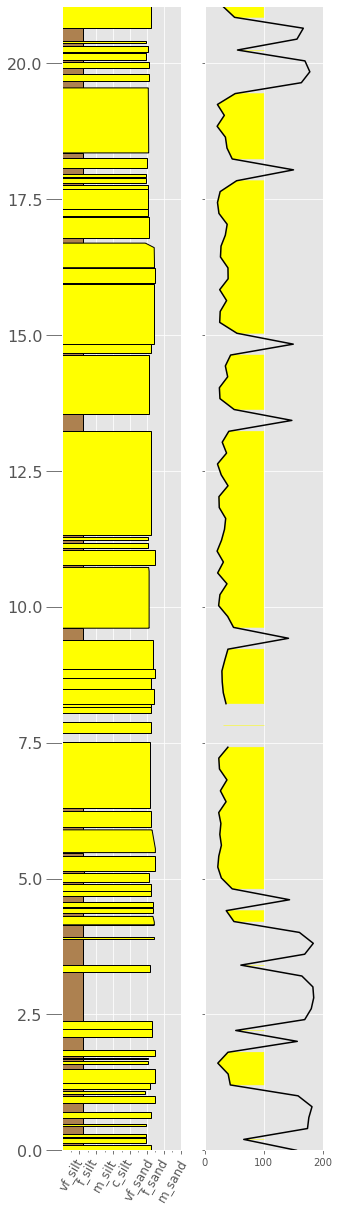

In [198]:
# Showing default values:
ds, pgr = example_seq.pseudo_gamma_simple(
    gs_field='grain_size_mm',
    depth_field='depth_m',
    resolution=0.2,
    gs_cutoff=0.0625,
    gamma_range=(30, 180),
    sigma=0.1,
    noise=10.
)

fig, ax = strip_fig_extra_columns(0, example_seq, 2, aspect=9)

cutoff = 100

ax[1].plot(pgr, ds, 'k')
ax[1].fill_betweenx(ds, pgr, np.repeat(cutoff, ds.size), where=(pgr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

# Ignore below here for now

In [ ]:






def gradient_fill(x, y, ax, pos_or_neg,
                  fill_color=None,
                  **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    ax : a matplotlib Axes instance
        The axes to plot on.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.
    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    x[np.argwhere(np.isnan(x))] = 0.

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    if pos_or_neg=='positive':
        alpha_gradient = np.linspace(0.2, alpha, 100)
        xmin, xmax = 0., ax.get_xlim()[1]
    else:
        alpha_gradient = np.linspace(alpha, 0.2, 100)
        xmin, xmax = ax.get_xlim()[0], 0.

    z = np.empty((1, 100, 4), dtype=float)
    z[:,:,-1] = alpha_gradient[None,:]

    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb

    ymin, ymax = y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.flipud(xy) if y[0] < y[1] else xy   # Have to flip order for 'depth'-ordered striplogs
    if pos_or_neg=='positive':
        xy = np.vstack([[xmin, ymax], xy, [xmin, ymin], [xmin, ymax]])
    else:
        xy = np.vstack([[xmax, ymax], xy, [xmax, ymin], [xmax, ymax]])

    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

# Plotting with convolution "gamma ray"

In [ ]:
# using astropy.convolve for now

def pseudo_gamma_simple(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    gamma_range = (180, 30) # Low/High values
    resolution = 0.05       # Depth resolution
    sigma = 2              # Gaussian filter width
    noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


fig, ax = strip_fig_extra_columns(0, seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma_simple(seqs[0])
gradient_fill(gr, ds, ax[1], 'positive', fill_color='y')
ax[1].set_xlim([0,200])

In [ ]:
from scipy.ndimage import gaussian_filter1d

def filter_nan_gaussian(arr, sigma):
    """

    (Allows intensity to leak into the NaN area.)

    Implementation from stackoverflow answer:
        https://stackoverflow.com/a/36307291/7128154
    """
    gauss = arr.copy()
    gauss[np.isnan(gauss)] = 0
    gauss = gaussian_filter1d(gauss, sigma=sigma, mode='constant', cval=0)

    norm = np.ones(shape=arr.shape)
    norm[np.isnan(arr)] = 0
    norm = gaussian_filter1d(norm, sigma=sigma, mode='constant', cval=0)

    # avoid RuntimeWarning: invalid value encountered in true_divide
    norm = np.where(norm==0, 1, norm)
    gauss = gauss/norm
    gauss[np.isnan(arr)] = np.nan
    return gauss

def pseudo_gamma_simple(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    gamma_range = (180, 30) # Low/High values
    resolution = 0.05       # Depth resolution
    sigma = 2              # Gaussian filter width
    noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    #kernel = Gaussian1DKernel(sigma) # divided by resolution?
    #conv_gr = convolve(sample_gr, kernel)
    conv_gr = filter_nan_gaussian(sample_gr, sigma)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


fig, ax = strip_fig_extra_columns(0, seqs[0], 2, aspect=9)

cutoff = 100

ds, gr = pseudo_gamma_simple(seqs[0])
#gradient_fill(gr, ds, ax[1], 'positive', fill_color='y')

ax[1].plot(gr, ds)
ax[1].fill_betweenx(ds, gr, np.repeat(cutoff, ds.size), where=(gr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

## these functions stolen from Matt Bauer



In [ ]:
import matplotlib as mpl

def rect(ax,x,y,w,h,c):
    #Make rectangle with plt.Rectangle((x,y@ Lower left),width,height,color)
    polygon = plt.Rectangle((x,y),w,h,color=c)
    #Add it to axis
    ax.add_patch(polygon)

def GR_fill(ax,X,Y):
    plt.plot(X,Y,lw=0)
    
    #Make a custom color ramp
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["yellow","yellow",'goldenrod','darkgoldenrod',"dimgrey",'black','black'])
    
    #Step distance
    dy = Y[1]-Y[0]
    
    #Max GR value
    N  = float(np.nanmax(X))
    
    #Make rectangles with color based on GR values
    for n, (x,y) in enumerate(zip(X,Y)):
        color = cmap(x/N)
        rect(ax,x,y,N-x,dy,color)
        
        
fig, ax = strip_fig_extra_columns(1 ,seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma_simple(seqs[0])
ax[0].plot(gr,ds,'k')
GR_fill(ax[0], gr, ds)
ax[0].set_xlim([0,200])
ax[1].set_title(seqs[0].metadata['name'])
plt.show()
#plt.savefig('/Users/zanejobe/Desktop/testT.pdf')

In [ ]:
def pseudo_gamma_args(seq, gamma_range, resolution, sigma, noise_magnitude):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    #gamma_range = (180, 30) # Low/High values
    #resolution = 0.05       # Depth resolution
    #sigma = 2              # Gaussian filter width
    #noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


In [238]:
# why NaNs here?
np.isnan(seqs[0].values).sum()

36

In [236]:
seqs[-1][0].data #pukearuhue first bed

{'th': 0.23464504599417105,
 'gs_tops_mm': 0.010289315855149,
 'snd_shl': 0.0,
 'depth_m': array([66.907 , 66.6724]),
 'mean_gs_mm': 0.010289315855149,
 'max_gs_mm': 0.010289315855149,
 'grain_size_mm': [0.0103, 0.0103],
 'gs_tops_psi': -6.6027,
 'mean_gs_psi': -6.6027,
 'max_gs_psi': -6.6027,
 'grain_size_psi': [-6.6012, -6.6012]}

In [235]:
# fixing weird mud bed thats a colloid at the top of the section...

# DID THIS GET CHANGED IN THE DATA FILE???
Puk=-1
seqs[Puk][0].data['gs_tops_mm'] = 0.010289315855149
seqs[Puk][0].data['mean_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['mean_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['max_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['grain_size_mm'] = [0.0103, 0.0103]
seqs[Puk][0].data['gs_tops_psi'] = -6.6027
seqs[Puk][0].data['mean_gs_psi'] = -6.6027
seqs[Puk][0].data['max_gs_psi'] = -6.6027
seqs[Puk][0].data['grain_size_psi'] = [-6.6012, -6.6012]

In [ ]:
# Ross, what is this for? 
demo_names = ['Pukearuhue', 'Magnolia', 'Karoo krf']
seq_rows = [beds[beds['name'].str.contains(dn)] for dn in demo_names]
demo_df = pd.concat(seq_rows)
demo_df.to_csv('../data/demo_sequences.csv', index=False)
